In [78]:
"""
fast_lds_scan.py

What this gives you
-------------------
1) A Mamba/S4-style *parallel associative scan* for the diagonal LDS recurrence
      h_{t+1} = A ⊙ h_t + B ⊙ u_t
      y_t     = h_{t+1} @ C

2) Two LDS modules:
   - FixedDiagonalLDS: buffers + no_grad + in-place scan (fastest when A,B,C,h0 are fixed)
   - TrainableDiagonalLDS: parameters + differentiable scan (used for the demo that *learns* an LDS)

3) DistillSTUFast:
   - Runs the fixed LDS per input feature (your flattening trick)
   - Learns a single mixing tensor M from scratch (M_phi_plus and M_phi_minus concatenated)
   - Uses reshape + GEMM (no tensordot)

4) Demo requested:
   - Create a random teacher LDS with each A_i in (-1, 1)
   - Train a student LDS (A,B,C,h0) to match teacher outputs (MSE)

Run:
  python fast_lds_scan.py
"""

import math
from typing import Optional, List

import torch
import torch.nn as nn
import torch.nn.functional as F


# ============================================================
#  Parallel associative scan for affine maps
# ============================================================
def affine_scan_inclusive(a: torch.Tensor, b: torch.Tensor):
    """
    Differentiable Hillis–Steele inclusive scan for elementwise affine maps.

    Each timestep t represents: f_t(x) = a_t * x + b_t   (elementwise on last dim)
    Composition (later ∘ earlier):
        (aL, bL) ⊗ (aR, bR) = (aL*aR, bL + aL*bR)

    After inclusive scan, (a_pref[t], b_pref[t]) equals f_t ∘ ... ∘ f_0.

    Args:
        a: (T, D)
        b: (..., T, D)

    Returns:
        a_pref: (T, D)
        b_pref: (..., T, D)
    """
    assert a.ndim == 2, f"a must be (T,D), got {a.shape}"
    assert b.shape[-2:] == a.shape, f"b must end with (T,D)={a.shape}, got {b.shape}"
    T, _ = a.shape

    a_out = a
    b_out = b
    offset = 1
    while offset < T:
        a_old = a_out
        b_old = b_out

        # Shift by offset with identity padding on the left:
        # a_shift[t] = 1 for t < offset, else a_old[t-offset]
        # b_shift[t] = 0 for t < offset, else b_old[t-offset]
        a_shift = F.pad(a_old[:-offset, :], (0, 0, offset, 0), mode="constant", value=1.0)
        b_shift = F.pad(b_old[..., :-offset, :], (0, 0, offset, 0), mode="constant", value=0.0)

        # IMPORTANT: b update uses a_old (not the updated a)
        b_out = b_old + a_old * b_shift
        a_out = a_old * a_shift
        offset <<= 1

    return a_out, b_out


@torch.no_grad()
def affine_scan_inclusive_inplace(a: torch.Tensor, b: torch.Tensor):
    """
    In-place version of the same scan, intended for no_grad usage only.
    Uses temporary buffers for the update step to avoid data hazards.

    Args:
        a: (T, D)  (will be overwritten)
        b: (..., T, D)  (will be overwritten)

    Returns:
        (a, b) overwritten to prefix-composed transforms.
    """
    T = a.shape[0]
    offset = 1
    while offset < T:
        aL = a[offset:]
        aR = a[:-offset]
        bL = b[..., offset:, :]
        bR = b[..., :-offset, :]

        # Use temp storage to avoid read-after-write hazards in overlapping slices
        # b[offset:] = b[offset:] + a[offset:] * b[:-offset]
        b[..., offset:, :] = bL + aL * bR

        # a[offset:] = a[offset:] * a[:-offset]
        a[offset:] = aL * aR

        offset <<= 1
    return a, b


@torch.no_grad()
def affine_scan_with_fixed_a(b: torch.Tensor, a_steps: List[torch.Tensor]):
    """
    Optimized scan where 'a' evolution is precomputed.

    b: (..., T, D)
    a_steps: list of 'aL' tensors for each offset step.
    """
    T = b.shape[-2]
    offset = 1
    step_idx = 0
    while offset < T:
        # b[offset:] += a_step * b[:-offset]
        # We must avoid in-place hazard. standard addcmul does not guarantee safety on self-overlap.
        # So we simply compute RHS and assign.
        aL = a_steps[step_idx]
        b[..., offset:, :] = b[..., offset:, :] + aL * b[..., :-offset, :]

        offset <<= 1
        step_idx += 1
    return b


# ============================================================
#  Fixed diagonal LDS (fastest for your real use-case)
# ============================================================
class FixedDiagonalLDS(nn.Module):
    """
    Fixed diagonal LDS (buffers), scalar input:

        h_{t+1} = A ⊙ h_t + B ⊙ u_t
        y_t     = h_{t+1} @ C

    A: (D,)
    B_vec: (D,)
    C: (D,O)
    h0: (D,)

    Forward uses in-place parallel scan under torch.no_grad().
    """

    def __init__(
        self,
        A: torch.Tensor,
        B_vec: torch.Tensor,
        C: torch.Tensor,
        h0: Optional[torch.Tensor] = None,
    ):
        super().__init__()
        assert A.ndim == 1
        D = A.numel()
        assert B_vec.shape == (D,)
        assert C.shape[0] == D
        if h0 is None:
            h0 = torch.zeros(D, device=A.device, dtype=A.dtype)
        assert h0.shape == (D,)

        self.register_buffer("A", A.detach().clone())
        self.register_buffer("B_vec", B_vec.detach().clone())
        self.register_buffer("C", C.detach().clone())
        self.register_buffer("h0", h0.detach().clone())

        self.a_cache = {}  # Cache for precomputed scan parameters
        self.a_final_cache = {}

    @torch.no_grad()
    def precompute_scan_A(self, T: int):
        """Precompute A evolution for a specific sequence length T."""
        if T in self.a_cache:
            return

        D = self.A.numel()
        a = self.A.view(1, D).repeat(T, 1) # (T, D)

        steps = []
        offset = 1
        while offset < T:
            aL = a[offset:]
            aR = a[:-offset]
            steps.append(aL.clone())

            # Evolve a safely (no hazard since we assign the result of mul)
            a[offset:] = aL * aR
            offset <<= 1

        self.a_cache[T] = steps
        self.a_final_cache[T] = a  # This is the final prefix product

    @torch.no_grad()
    def forward(self, u: torch.Tensor) -> torch.Tensor:
        """
        u: (N,T) or (N,T,1)
        returns: (N,T,O)
        """
        if u.ndim == 3:
            assert u.shape[-1] == 1
            u = u[..., 0]
        assert u.ndim == 2

        N, T = u.shape
        D = self.A.numel()

        # b_t = u_t * B_vec -> (N,T,D)
        b = u.unsqueeze(-1) * self.B_vec.view(1, 1, D)

        if T in self.a_cache:
            # Use optimized path with precomputed A steps
            b_pref = affine_scan_with_fixed_a(b, self.a_cache[T])
            a_pref = self.a_final_cache[T]
        else:
            # Standard path: compute a on the fly
            a = self.A.view(1, D).repeat(T, 1)
            a_pref, b_pref = affine_scan_inclusive_inplace(a, b)

        # h_{t+1} = a_pref[t]*h0 + b_pref[t]
        h_seq = b_pref + a_pref.unsqueeze(0) * self.h0.view(1, 1, D)

        # y_t = h_{t+1} @ C
        return h_seq @ self.C


# ============================================================
#  Trainable diagonal LDS (for demo: learn a random LDS)
# ============================================================
class TrainableDiagonalLDS(nn.Module):
    """
    Trainable diagonal LDS, scalar input, differentiable parallel scan:

        h_{t+1} = A ⊙ h_t + B ⊙ u_t
        y_t     = h_{t+1} @ C

    Constraint: each A_i is in (-1, 1) via A = tanh(A_logit).
    """

    def __init__(
        self,
        state_dim: int,
        output_dim: int,
        dtype: torch.dtype = torch.float32,
        device: Optional[torch.device] = None,
    ):
        super().__init__()
        device = device or torch.device("cpu")

        self.state_dim = state_dim
        self.output_dim = output_dim

        # A_i in (-1,1)
        self.A_logit = nn.Parameter(torch.zeros(state_dim, dtype=dtype, device=device))

        self.B_vec = nn.Parameter(
            torch.randn(state_dim, dtype=dtype, device=device) / math.sqrt(state_dim)
        )
        self.C = nn.Parameter(
            torch.randn(state_dim, output_dim, dtype=dtype, device=device) / math.sqrt(state_dim)
        )
        self.h0 = nn.Parameter(torch.zeros(state_dim, dtype=dtype, device=device))

    @property
    def A(self) -> torch.Tensor:
        return torch.tanh(self.A_logit)

    def forward(self, u: torch.Tensor) -> torch.Tensor:
        """
        u: (N,T) or (N,T,1)
        returns: (N,T,O)
        """
        if u.ndim == 3:
            assert u.shape[-1] == 1
            u = u[..., 0]
        assert u.ndim == 2

        N, T = u.shape
        D = self.state_dim
        A = self.A  # (D,)

        b = u.unsqueeze(-1) * self.B_vec.view(1, 1, D)  # (N,T,D)
        a = A.view(1, D).repeat(T, 1)                   # (T,D)

        a_pref, b_pref = affine_scan_inclusive(a, b)
        h_seq = b_pref + a_pref.unsqueeze(0) * self.h0.view(1, 1, D)

        return h_seq @ self.C


# ============================================================
#  DistillSTU-style module: fixed LDS features + learn M from scratch
# ============================================================
class DistillSTUFast(nn.Module):
    """
    x: (B,T,d_in) -> y: (B,T,d_out)

    Steps:
      - Flatten features into batch: u = x.permute(0,2,1).reshape(B*d_in, T)
      - Fixed LDS -> U: (B*d_in, T, n_filters)
      - Reshape U -> (B,T,n_filters,d_in)
      - One GEMM with M reshaped (n_filters*d_in, d_out)
    """

    def __init__(
        self,
        lds: FixedDiagonalLDS,
        K: int,
        d_in: int,
        d_out: int,
        use_hankel_L: bool = False,
        dtype: torch.dtype = torch.float32,
    ):
        super().__init__()
        self.lds = lds
        self.K = K
        self.d_in = d_in
        self.d_out = d_out
        self.use_hankel_L = use_hankel_L

        self.n_filters = self.K if use_hankel_L else 2 * self.K

        # Learn from scratch
        self.M = nn.Parameter(
            torch.randn(self.n_filters, self.d_in, self.d_out, dtype=dtype, device=self.lds.A.device)
            / math.sqrt(self.n_filters * self.d_in)
        )

    def forward(self, x: torch.Tensor, feature_chunk: Optional[int] = None) -> torch.Tensor:
        if x.ndim == 2:
            x = x.unsqueeze(-1)
        B, T, d_in = x.shape
        assert d_in == self.d_in

        M_flat = self.M.reshape(self.n_filters * d_in, self.d_out)

        # No chunking
        if feature_chunk is None or feature_chunk >= d_in:
            u = x.permute(0, 2, 1).contiguous().reshape(-1, T)  # (B*d_in, T)
            U = self.lds(u)  # (B*d_in, T, n_filters)

            U = U.reshape(B, d_in, T, self.n_filters).permute(0, 2, 3, 1).contiguous()  # (B,T,n_filters,d_in)
            out = U.reshape(B * T, self.n_filters * d_in) @ M_flat
            return out.reshape(B, T, self.d_out)

        # Chunked over features (lower peak memory)
        out = x.new_zeros((B, T, self.d_out))
        for s in range(0, d_in, feature_chunk):
            e = min(d_in, s + feature_chunk)
            chunk = e - s

            x_chunk = x[:, :, s:e]  # (B,T,chunk)
            u = x_chunk.permute(0, 2, 1).contiguous().reshape(-1, T)  # (B*chunk,T)
            U = self.lds(u)  # (B*chunk,T,n_filters)

            U = U.reshape(B, chunk, T, self.n_filters).permute(0, 2, 3, 1).contiguous()  # (B,T,n_filters,chunk)

            M_chunk = self.M[:, s:e, :].contiguous().reshape(self.n_filters * chunk, self.d_out)
            out = out + (U.reshape(B * T, self.n_filters * chunk) @ M_chunk).reshape(B, T, self.d_out)

        return out

In [27]:
lds_path = "431_phi_lds.pt"
device = torch.device("cuda")

lds_data = torch.load(lds_path, map_location=device)['model_state_dict']
state_dim = lds_data['A'].shape[0]
input_dim = lds_data['B'].shape[0]
output_dim = lds_data['C'].shape[1]

# Initialize LDS with double precision

A = lds_data['A'].to(device).double()
B = lds_data['B'].to(device).double()
C = lds_data['C'].to(device).double()
lds = FixedDiagonalLDS(A, B.flatten(), C)

print("LDS loaded and cast to float64.")


LDS loaded and cast to float64.


In [28]:
#  DistillSTU-style module: fixed LDS features + learn M from scratch
# ============================================================
class DistillSTUFast(nn.Module):
    """
    x: (B,T,d_in) -> y: (B,T,d_out)

    Steps:
      - Flatten features into batch: u = x.permute(0,2,1).reshape(B*d_in, T)
      - Fixed LDS -> U: (B*d_in, T, n_filters)
      - Reshape U -> (B,T,n_filters,d_in)
      - One GEMM with M reshaped (n_filters*d_in, d_out)
    """

    def __init__(
        self,
        lds: FixedDiagonalLDS,
        K: int,
        d_in: int,
        d_out: int,
        use_hankel_L: bool = False,
        dtype: torch.dtype = torch.float64,
    ):
        super().__init__()
        self.lds = lds
        self.K = K
        self.d_in = d_in
        self.d_out = d_out
        self.use_hankel_L = use_hankel_L

        self.n_filters = self.K if use_hankel_L else 2 * self.K

        # Learn from scratch
        self.M = nn.Parameter(
            torch.randn(self.n_filters, self.d_in, self.d_out, dtype=dtype, device=self.lds.A.device)
            / math.sqrt(self.n_filters * self.d_in)
        )

    def forward(self, x: torch.Tensor, feature_chunk: Optional[int] = None) -> torch.Tensor:
        if x.ndim == 2:
            x = x.unsqueeze(-1)
        B, T, d_in = x.shape
        assert d_in == self.d_in

        M_flat = self.M.reshape(self.n_filters * d_in, self.d_out)

        # No chunking
        if feature_chunk is None or feature_chunk >= d_in:
            u = x.permute(0, 2, 1).contiguous().reshape(-1, T)  # (B*d_in, T)
            U = self.lds(u)  # (B*d_in, T, n_filters)

            U = U.reshape(B, d_in, T, self.n_filters).permute(0, 2, 3, 1).contiguous()  # (B,T,n_filters,d_in)
            out = U.reshape(B * T, self.n_filters * d_in) @ M_flat
            return out.reshape(B, T, self.d_out)

        # Chunked over features (lower peak memory)
        out = x.new_zeros((B, T, self.d_out))
        for s in range(0, d_in, feature_chunk):
            e = min(d_in, s + feature_chunk)
            chunk = e - s

            x_chunk = x[:, :, s:e]  # (B,T,chunk)
            u = x_chunk.permute(0, 2, 1).contiguous().reshape(-1, T)  # (B*chunk,T)
            U = self.lds(u)  # (B*chunk,T,n_filters)

            U = U.reshape(B, chunk, T, self.n_filters).permute(0, 2, 3, 1).contiguous()  # (B,T,n_filters,chunk)

            M_chunk = self.M[:, s:e, :].contiguous().reshape(self.n_filters * chunk, self.d_out)
            out = out + (U.reshape(B * T, self.n_filters * chunk) @ M_chunk).reshape(B, T, self.d_out)

        return out


In [53]:
import matplotlib.pyplot as plt
from typing import Optional

# ============================================================
#  DEMO: learn a randomly initialized LDS (teacher) with A_i in (-1,1)
# ============================================================
def demo_learn_random_lds(
    steps: int = 500,
    batch_size: int = 64,
    seq_len: int = 128,
    state_dim: int = 32,
    output_dim: int = 8,
    lr: float = 1e-1,
    seed: int = 0,
    dtype: torch.dtype = torch.float32,
    base_lds: Optional[FixedDiagonalLDS] = None,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if device.type == "cuda":
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.set_float32_matmul_precision("high")

    print(f"[demo] dtype={dtype}, device={device}, steps={steps}, B={batch_size}, T={seq_len}, D={state_dim}, O={output_dim}")

    # ========================================================
    # Robust Seeding Strategy: Pre-generate all random tensors
    # in float32 to ensure identical values across runs.
    # ========================================================
    gen_dtype = torch.float32
    rng_state = torch.get_rng_state()
    torch.manual_seed(seed)

    # 1. Teacher Parameters
    A_teacher_gen = torch.empty(state_dim, dtype=gen_dtype, device=device).uniform_(-0.99, 0.99)
    B_teacher_gen = torch.randn(state_dim, dtype=gen_dtype, device=device) / math.sqrt(state_dim)
    C_teacher_gen = torch.randn(state_dim, output_dim, dtype=gen_dtype, device=device) / math.sqrt(state_dim)
    h0_teacher_gen = torch.zeros(state_dim, dtype=gen_dtype, device=device) / math.sqrt(state_dim)

    # 2. Validation Data
    u_val_gen = torch.randn(1, seq_len, device=device, dtype=gen_dtype)

    # 3. Student Initialization (M matrix)
    # We need to know the shape of M ahead of time or just generate enough noise.
    # Based on DistillSTUFast logic: n_filters * d_in * d_out
    # K=24, use_hankel=False -> n_filters=48. d_in=1. d_out=output_dim.
    K = 24
    d_in = 1
    n_filters = 2 * K  # Since use_hankel_L=False
    M_shape = (n_filters, d_in, output_dim)
    M_scale = 1.0 / math.sqrt(n_filters * d_in)
    M_init_gen = torch.randn(M_shape, dtype=gen_dtype, device=device) * M_scale

    print(f"  Teacher A sum (f32): {A_teacher_gen.sum().item():.5f}")
    print(f"  Val Input sum (f32): {u_val_gen.sum().item():.5f}")

    # ========================================================
    # Construct Modules (Cast to target dtype)
    # ========================================================

    teacher = FixedDiagonalLDS(
        A_teacher_gen.to(dtype=dtype),
        B_teacher_gen.to(dtype=dtype),
        C_teacher_gen.to(dtype=dtype),
        h0_teacher_gen.to(dtype=dtype)
    ).to(device)

    if base_lds is None:
        if 'lds' in globals():
            base_lds_ref = globals()['lds']
        else:
            raise ValueError("Global 'lds' not found and no base_lds provided.")
    else:
        base_lds_ref = base_lds

    # Cast basis to correct dtype
    basis_A = base_lds_ref.A.to(dtype=dtype, device=device)
    basis_B = base_lds_ref.B_vec.to(dtype=dtype, device=device)
    basis_C = base_lds_ref.C.to(dtype=dtype, device=device)
    basis_h0 = base_lds_ref.h0.to(dtype=dtype, device=device)

    student_basis = FixedDiagonalLDS(basis_A, basis_B, basis_C, basis_h0)

    # Initialize student (init will consume RNG, but we overwrite M)
    student = DistillSTUFast(student_basis, K, d_in, output_dim, use_hankel_L=False, dtype=dtype).to(device)

    # Force Overwrite M
    with torch.no_grad():
        student.M.copy_(M_init_gen.to(dtype=dtype))

    opt = torch.optim.Adagrad(student.parameters(), lr=lr, weight_decay=0.0)

    # ========================================================
    # Training Loop
    # ========================================================
    # Set a specific seed for the loop data generation to stay consistent
    torch.manual_seed(seed + 999)

    for step in range(steps + 1):
        # Always generate data in float32, then cast
        u_gen = torch.randn(batch_size, seq_len, device=device, dtype=gen_dtype)
        u = u_gen.to(dtype=dtype)

        # supervise from teacher
        with torch.no_grad():
            y = teacher(u)

        pred = student(u)
        loss = F.mse_loss(pred, y)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        if step in [0, 1, 2, 5, 10, 20, 50, 100, 200, steps] or (step % 25 == 0 and step > 0):
            print(f"step {step:4d} | loss {loss.item():.6e}")

    # ========================================================
    # Plot results
    # ========================================================
    print("Plotting validation sequences...")
    with torch.no_grad():
        u_val = u_val_gen.to(dtype=dtype)
        y_teacher = teacher(u_val)
        y_student = student(u_val)

    y_t = y_teacher[0].cpu().float().numpy()
    y_s = y_student[0].cpu().float().numpy()

    plt.figure(figsize=(12, 4))
    for i in range(min(3, output_dim)):
        plt.subplot(1, 3, i + 1)
        plt.plot(y_t[:, i], label='Teacher', linewidth=2, alpha=0.7)
        plt.plot(y_s[:, i], '--', label='Student', linewidth=2, alpha=0.7)
        plt.title(f"Output dim {i} ({dtype})")
        plt.legend()
    plt.tight_layout()
    plt.show()

    return teacher, student

=== Running with Float64 ===
[demo] dtype=torch.float64, device=cuda, steps=500, B=64, T=128, D=32, O=8
  Teacher A sum (f32): 1.05778
  Val Input sum (f32): 27.40876
step    0 | loss 6.646134e-02
step    1 | loss 2.660072e-02
step    2 | loss 1.673278e-02
step    5 | loss 4.908935e-03
step   10 | loss 1.863006e-03
step   20 | loss 4.465890e-04
step   25 | loss 2.407023e-04
step   50 | loss 2.351762e-05
step   75 | loss 4.897402e-06
step  100 | loss 1.895722e-06
step  125 | loss 1.278411e-06
step  150 | loss 7.355263e-07
step  175 | loss 5.173246e-07
step  200 | loss 4.864053e-07
step  225 | loss 3.409643e-07
step  250 | loss 2.796645e-07
step  275 | loss 2.077614e-07
step  300 | loss 2.083144e-07
step  325 | loss 1.896105e-07
step  350 | loss 1.852357e-07
step  375 | loss 1.314002e-07
step  400 | loss 1.552509e-07
step  425 | loss 1.111406e-07
step  450 | loss 1.242128e-07
step  475 | loss 1.132039e-07
step  500 | loss 1.100124e-07
Plotting validation sequences...


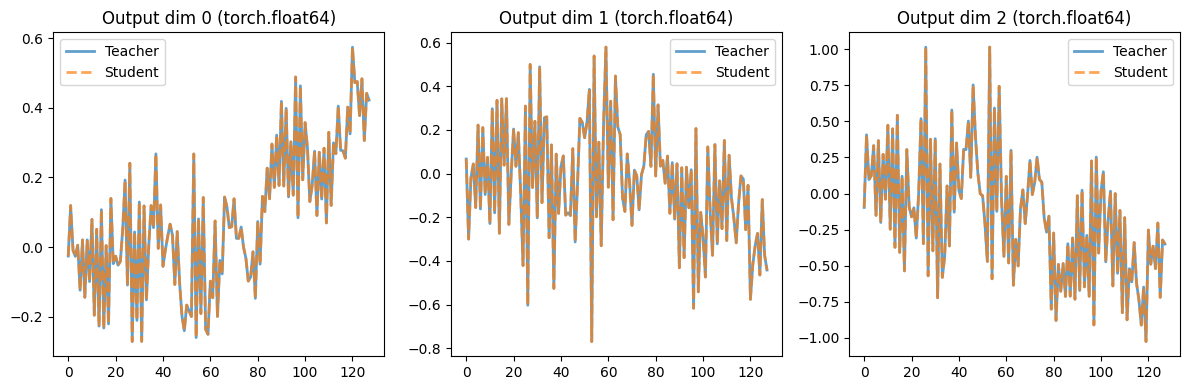


=== Running with Float32 ===
[demo] dtype=torch.float32, device=cuda, steps=500, B=64, T=128, D=32, O=8
  Teacher A sum (f32): 1.05778
  Val Input sum (f32): 27.40876
step    0 | loss 6.646731e-02
step    1 | loss 2.789420e-02
step    2 | loss 1.557821e-02
step    5 | loss 4.620453e-03
step   10 | loss 1.709622e-03
step   20 | loss 4.010373e-04
step   25 | loss 2.178193e-04
step   50 | loss 3.306432e-05
step   75 | loss 1.686997e-05
step  100 | loss 1.202985e-05
step  125 | loss 1.013813e-05
step  150 | loss 8.222034e-06
step  175 | loss 7.560967e-06
step  200 | loss 6.326757e-06
step  225 | loss 5.730822e-06
step  250 | loss 5.002754e-06
step  275 | loss 4.642286e-06
step  300 | loss 4.220597e-06
step  325 | loss 4.099669e-06
step  350 | loss 3.676735e-06
step  375 | loss 3.223020e-06
step  400 | loss 3.263629e-06
step  425 | loss 2.905922e-06
step  450 | loss 2.804567e-06
step  475 | loss 2.493682e-06
step  500 | loss 2.445362e-06
Plotting validation sequences...


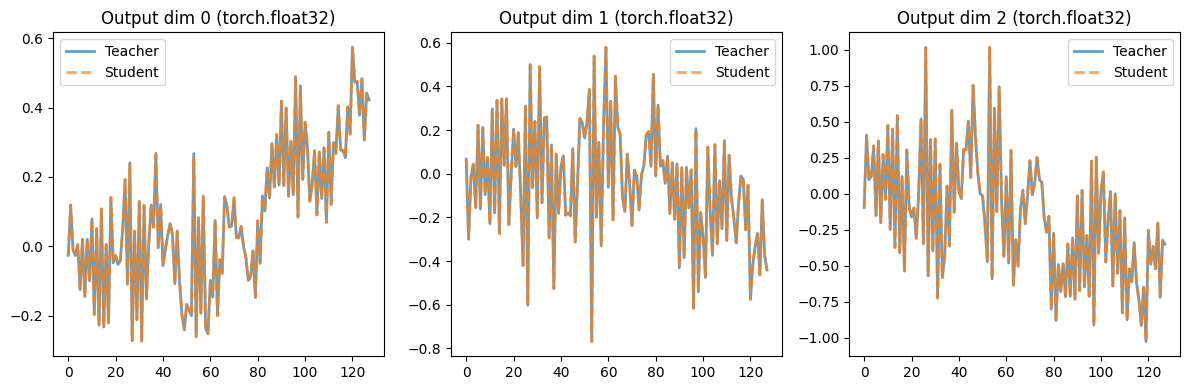

(FixedDiagonalLDS(),
 DistillSTUFast(
   (lds): FixedDiagonalLDS()
 ))

In [54]:
print("=== Running with Float64 ===")
demo_learn_random_lds(dtype=torch.float64)

print("\n=== Running with Float32 ===")
demo_learn_random_lds(dtype=torch.float32)

=== Float64 Comparison ===
[demo_compare] dtype=torch.float64, device=cuda, steps=500, B=64, T=1024
step    0 | DistillSTU: 9.231314e-02 | MiniSTU: 9.088957e-02
step   50 | DistillSTU: 9.116713e-05 | MiniSTU: 1.297379e-04
step  100 | DistillSTU: 3.232307e-06 | MiniSTU: 8.306000e-06
step  150 | DistillSTU: 2.515855e-07 | MiniSTU: 7.601598e-07
step  200 | DistillSTU: 1.066466e-07 | MiniSTU: 2.234370e-07
step  250 | DistillSTU: 8.109807e-08 | MiniSTU: 1.335540e-07
step  300 | DistillSTU: 7.001191e-08 | MiniSTU: 1.015685e-07
step  350 | DistillSTU: 5.107486e-08 | MiniSTU: 6.998632e-08
step  400 | DistillSTU: 5.411140e-08 | MiniSTU: 6.293749e-08
step  450 | DistillSTU: 4.964075e-08 | MiniSTU: 5.215402e-08
step  500 | DistillSTU: 4.293957e-08 | MiniSTU: 4.304607e-08
Plotting Comparison...


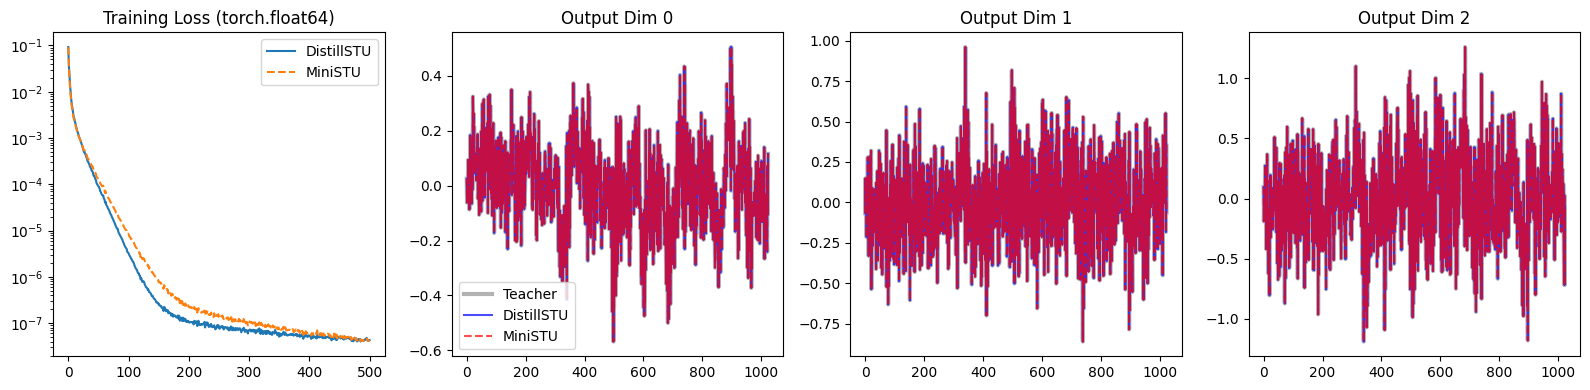


=== Float32 Comparison ===
[demo_compare] dtype=torch.float32, device=cuda, steps=500, B=64, T=1024
step    0 | DistillSTU: 9.244178e-02 | MiniSTU: 9.088957e-02
step   50 | DistillSTU: 9.845303e-05 | MiniSTU: 1.297386e-04
step  100 | DistillSTU: 2.015331e-05 | MiniSTU: 8.306055e-06
step  150 | DistillSTU: 1.242421e-05 | MiniSTU: 7.601591e-07
step  200 | DistillSTU: 9.388884e-06 | MiniSTU: 2.234366e-07
step  250 | DistillSTU: 7.486219e-06 | MiniSTU: 1.335524e-07
step  300 | DistillSTU: 6.418080e-06 | MiniSTU: 1.015671e-07
step  350 | DistillSTU: 5.418886e-06 | MiniSTU: 6.998521e-08
step  400 | DistillSTU: 4.790448e-06 | MiniSTU: 6.293651e-08
step  450 | DistillSTU: 4.439122e-06 | MiniSTU: 5.215309e-08
step  500 | DistillSTU: 3.929921e-06 | MiniSTU: 4.304523e-08
Plotting Comparison...


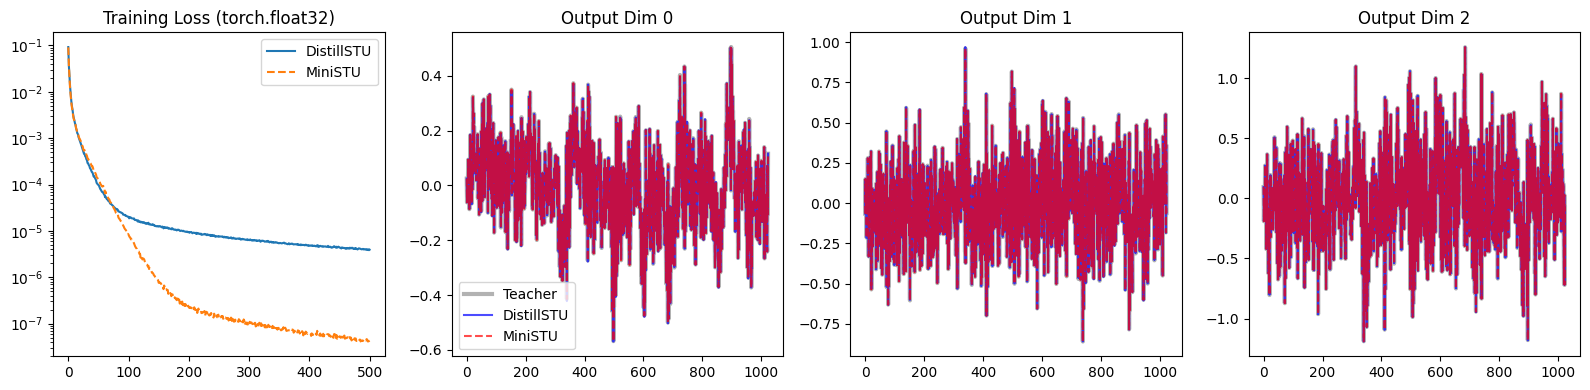

(DistillSTUFast(
   (lds): FixedDiagonalLDS()
 ),
 MiniSTU())

In [80]:
# ============================================================
#  DEMO: Compare DistillSTUFast vs MiniSTU
# ============================================================
def demo_compare_stu(
    steps: int = 500,
    batch_size: int = 64,
    seq_len: int = 1024,
    state_dim: int = 32,
    output_dim: int = 8,
    lr: float = 1e-1,
    seed: int = 0,
    dtype: torch.dtype = torch.float32,
    base_lds: Optional[FixedDiagonalLDS] = None,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[demo_compare] dtype={dtype}, device={device}, steps={steps}, B={batch_size}, T={seq_len}")

    # 1. Robust Seeding & Data Generation (float32)
    gen_dtype = torch.float32
    torch.manual_seed(seed)

    # Teacher params
    A_teacher = torch.empty(state_dim, dtype=gen_dtype, device=device).uniform_(-0.99, 0.99)
    B_teacher = torch.randn(state_dim, dtype=gen_dtype, device=device) / math.sqrt(state_dim)
    C_teacher = torch.randn(state_dim, output_dim, dtype=gen_dtype, device=device) / math.sqrt(state_dim)
    h0_teacher = torch.zeros(state_dim, dtype=gen_dtype, device=device) / math.sqrt(state_dim)

    # Shared Student Initialization (M matrix)
    # K=24, d_in=1. n_filters=48.
    K = 24
    d_in = 1
    n_filters = 2 * K
    M_shape = (n_filters, d_in, output_dim)
    M_scale = 1.0 / math.sqrt(n_filters * d_in)
    M_init_gen = torch.randn(M_shape, dtype=gen_dtype, device=device) * M_scale

    # Validation Data
    u_val_gen = torch.randn(1, seq_len, device=device, dtype=gen_dtype)

    # 2. Instantiate Models
    # Teacher
    teacher = FixedDiagonalLDS(
        A_teacher.to(dtype=dtype),
        B_teacher.to(dtype=dtype),
        C_teacher.to(dtype=dtype),
        h0_teacher.to(dtype=dtype)
    ).to(device)

    # Student 1: DistillSTUFast
    if base_lds is None:
        if 'lds' in globals():
            base_lds_ref = globals()['lds']
        else:
            raise ValueError("Global 'lds' not found and no base_lds provided.")
    else:
        base_lds_ref = base_lds

    # Cast basis to correct dtype
    basis_A = base_lds_ref.A.to(dtype=dtype, device=device)
    basis_B = base_lds_ref.B_vec.to(dtype=dtype, device=device)
    basis_C = base_lds_ref.C.to(dtype=dtype, device=device)
    basis_h0 = base_lds_ref.h0.to(dtype=dtype, device=device)
    student1_basis = FixedDiagonalLDS(basis_A, basis_B, basis_C, basis_h0)

    student1 = DistillSTUFast(student1_basis, K, d_in, output_dim, use_hankel_L=False, dtype=dtype).to(device)

    # Student 2: MiniSTU
    student2 = MiniSTU(seq_len, K, d_in, output_dim, use_hankel_L=False, dtype=dtype, device=device).to(device)

    # 3. Synchronize Initialization
    # DistillSTUFast.M: (2*K, d_in, d_out)
    # MiniSTU.M_phi_plus: (K, d_in, d_out)
    # MiniSTU.M_phi_minus: (K, d_in, d_out)
    with torch.no_grad():
        M_tensor = M_init_gen.to(dtype=dtype)
        student1.M.copy_(M_tensor)
        # Assume split is first half / second half
        student2.M_phi_plus.copy_(M_tensor[:K])
        student2.M_phi_minus.copy_(M_tensor[K:])

    # 4. Optimizers
    opt1 = torch.optim.Adagrad(student1.parameters(), lr=lr, weight_decay=0.0)
    opt2 = torch.optim.Adagrad(student2.parameters(), lr=lr, weight_decay=0.0)

    # 5. Training Loop
    loss1_hist = []
    loss2_hist = []

    torch.manual_seed(seed + 999)
    for step in range(steps + 1):
        u_gen = torch.randn(batch_size, seq_len, device=device, dtype=gen_dtype)
        u = u_gen.to(dtype=dtype)

        with torch.no_grad():
            y = teacher(u)

        # Student 1
        pred1 = student1(u)
        loss1 = F.mse_loss(pred1, y)
        opt1.zero_grad(set_to_none=True)
        loss1.backward()
        opt1.step()
        loss1_hist.append(loss1.item())

        # Student 2
        # MiniSTU expects (B, T, 1) if d_in=1
        pred2 = student2(u.unsqueeze(-1))
        loss2 = F.mse_loss(pred2, y)
        opt2.zero_grad(set_to_none=True)
        loss2.backward()
        opt2.step()
        loss2_hist.append(loss2.item())

        if step % 50 == 0:
            print(f"step {step:4d} | DistillSTU: {loss1.item():.6e} | MiniSTU: {loss2.item():.6e}")

    # 6. Plotting
    print("Plotting Comparison...")
    with torch.no_grad():
        u_val = u_val_gen.to(dtype=dtype)
        y_teacher = teacher(u_val)
        y_s1 = student1(u_val)
        y_s2 = student2(u_val.unsqueeze(-1))

    y_t = y_teacher[0].cpu().float().numpy()
    y_1 = y_s1[0].cpu().float().numpy()
    y_2 = y_s2[0].cpu().float().numpy()

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    # Loss curve
    axs[0].plot(loss1_hist, label='DistillSTU')
    axs[0].plot(loss2_hist, '--', label='MiniSTU')
    axs[0].set_yscale('log')
    axs[0].set_title(f'Training Loss ({dtype})')
    axs[0].legend()

    # Output dims
    for i in range(3):
        ax = axs[i+1]
        ax.plot(y_t[:, i], 'k-', alpha=0.3, label='Teacher', linewidth=3)
        ax.plot(y_1[:, i], 'b-', label='DistillSTU', alpha=0.7)
        ax.plot(y_2[:, i], 'r--', label='MiniSTU', alpha=0.7)
        ax.set_title(f'Output Dim {i}')
        if i == 0: ax.legend()

    plt.tight_layout()
    plt.show()

    return student1, student2

# Run comparison
print("=== Float64 Comparison ===")
demo_compare_stu(dtype=torch.float64)

print("\n=== Float32 Comparison ===")
demo_compare_stu(dtype=torch.float32)

In [84]:
import time
import torch._dynamo

def benchmark_stu_variants(
    d_in: int = 32,
    steps: int = 200,
    batch_size: int = 64,
    seq_len: int = 1024,
    state_dim: int = 32,
    output_dim: int = 8,
    lr: float = 5e-2,
    seed: int = 42,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n{'='*60}")
    print(f"BENCHMARK (reduce-overhead): d_in={d_in}, steps={steps}, B={batch_size}, T={seq_len}")
    print(f"{'='*60}")

    # Reset dynamo to ensure recompilation with new mode
    torch._dynamo.reset()

    dtypes = [torch.bfloat16, torch.float32, torch.float64]
    results = []

    for dtype in dtypes:
        print(f"\n>>> Testing dtype: {dtype}")

        # 1. Setup Data & Teacher
        torch.manual_seed(seed)
        gen_dtype = torch.float32

        # Teacher params
        A_gen = torch.empty(state_dim, dtype=gen_dtype, device=device).uniform_(-0.99, 0.99)
        B_gen = torch.randn(state_dim, dtype=gen_dtype, device=device) / math.sqrt(state_dim)
        C_gen = torch.randn(state_dim, output_dim, dtype=gen_dtype, device=device) / math.sqrt(state_dim)
        h0_gen = torch.randn(state_dim, dtype=gen_dtype, device=device) / math.sqrt(state_dim)

        # Input mixing
        W_in_gen = torch.randn(d_in, 1, dtype=gen_dtype, device=device) / math.sqrt(d_in)

        # LDS
        teacher_lds = FixedDiagonalLDS(
            A_gen.to(dtype=dtype), B_gen.to(dtype=dtype), C_gen.to(dtype=dtype), h0_gen.to(dtype=dtype)
        ).to(device)
        W_in = W_in_gen.to(dtype=dtype)

        def get_teacher_output(u_batch):
            u_mix = u_batch @ W_in
            return teacher_lds(u_mix[..., 0])

        # Pre-generate batches
        n_batches = 20
        train_data = []
        for _ in range(n_batches):
            u = torch.randn(batch_size, seq_len, d_in, device=device, dtype=dtype)
            with torch.no_grad():
                y = get_teacher_output(u)
            train_data.append((u, y))

        # 2. Setup Students
        K = 24
        n_filters = 2 * K
        M_shape = (n_filters, d_in, output_dim)
        M_init = torch.randn(M_shape, dtype=gen_dtype, device=device) / math.sqrt(n_filters * d_in)
        M_init = M_init.to(dtype=dtype)

        # --- DistillSTUFast ---
        C_basis_gen = torch.randn(state_dim, n_filters, dtype=gen_dtype, device=device) / math.sqrt(state_dim)

        basis_lds = FixedDiagonalLDS(
            teacher_lds.A,
            teacher_lds.B_vec,
            C_basis_gen.to(dtype=dtype),
            teacher_lds.h0
        )

        # Precompute the scan structure for faster forward pass
        basis_lds.precompute_scan_A(seq_len)

        stu_distill = DistillSTUFast(basis_lds, K, d_in, output_dim, use_hankel_L=False, dtype=dtype).to(device)
        with torch.no_grad():
            stu_distill.M.copy_(M_init)

        # --- MiniSTU ---
        stu_mini = MiniSTU(seq_len, K, d_in, output_dim, use_hankel_L=False, dtype=dtype, device=device).to(device)
        with torch.no_grad():
            stu_mini.M_phi_plus.copy_(M_init[:K])
            stu_mini.M_phi_minus.copy_(M_init[K:])

        models = [("DistillSTUFast", stu_distill), ("MiniSTU       ", stu_mini)]

        for name, model in models:
            # Compile with reduce-overhead to use CUDA Graphs
            try:
                model_opt = torch.compile(model, mode="reduce-overhead")
            except Exception as e:
                print(f"Compilation failed for {name}: {e}")
                model_opt = model

            opt = torch.optim.AdamW(model_opt.parameters(), lr=lr)

            # Warmup (triggers compilation)
            print(f"  [{name}] Warming up & Compiling...")
            for _ in range(5):
                u, y = train_data[0]
                loss = F.mse_loss(model_opt(u), y)
                loss.backward()
                opt.step()
                opt.zero_grad()

            torch.cuda.synchronize()
            start_t = time.time()

            final_loss = 0.0
            for i in range(steps):
                u, y = train_data[i % n_batches]
                pred = model_opt(u)
                loss = F.mse_loss(pred, y)

                opt.zero_grad(set_to_none=True)
                loss.backward()
                opt.step()

                final_loss = loss.item()

            torch.cuda.synchronize()
            end_t = time.time()

            avg_time = (end_t - start_t) / steps * 1000 # ms
            print(f"  [{name}] Time: {avg_time:6.2f} ms/step | Final Loss: {final_loss:.6e}")
            results.append((dtype, name, avg_time, final_loss))

    return results

print("Starting Benchmark (High Performance Mode)...")
benchmark_stu_variants()

Starting Benchmark (High Performance Mode)...

BENCHMARK (reduce-overhead): d_in=32, steps=200, B=64, T=1024

>>> Testing dtype: torch.bfloat16
  [DistillSTUFast] Warming up & Compiling...
  [DistillSTUFast] Time:   2.93 ms/step | Final Loss: 2.503395e-05
  [MiniSTU       ] Warming up & Compiling...
  [MiniSTU       ] Time:  10.34 ms/step | Final Loss: 6.628036e-05

>>> Testing dtype: torch.float32
  [DistillSTUFast] Warming up & Compiling...
  [DistillSTUFast] Time:   4.82 ms/step | Final Loss: 1.464194e-05
  [MiniSTU       ] Warming up & Compiling...
  [MiniSTU       ] Time:  10.72 ms/step | Final Loss: 6.545390e-05

>>> Testing dtype: torch.float64
  [DistillSTUFast] Warming up & Compiling...
  [DistillSTUFast] Time:  10.17 ms/step | Final Loss: 1.846138e-05
  [MiniSTU       ] Warming up & Compiling...
  [MiniSTU       ] Time:  17.92 ms/step | Final Loss: 7.120536e-05


[(torch.bfloat16, 'DistillSTUFast', 2.934354543685913, 2.5033950805664062e-05),
 (torch.bfloat16, 'MiniSTU       ', 10.335346460342407, 6.628036499023438e-05),
 (torch.float32, 'DistillSTUFast', 4.816458225250244, 1.4641935194958933e-05),
 (torch.float32, 'MiniSTU       ', 10.718752145767212, 6.545390351675451e-05),
 (torch.float64, 'DistillSTUFast', 10.170217752456665, 1.8461384924554157e-05),
 (torch.float64, 'MiniSTU       ', 17.918776273727417, 7.120536393402538e-05)]

In [85]:
import torch.profiler
from torch.profiler import profile, record_function, ProfilerActivity

def profile_model(model, input_tensor, steps=3):
    """Run torch.profiler on the model."""
    print(f"\nProfiling {type(model).__name__}...")

    # Warmup
    for _ in range(3):
        _ = model(input_tensor)

    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    ) as prof:
        for i in range(steps):
            with record_function(f"model_step_{i}"):
                _ = model(input_tensor)

    print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

# 1. Setup Model & Input
d_in = 32
seq_len = 32768
batch_size = 64
output_dim = 8
K = 24
state_dim = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.bfloat16

# Create a dummy DistillSTUFast
lds_basis = FixedDiagonalLDS(
    torch.zeros(state_dim, device=device, dtype=dtype),
    torch.zeros(state_dim, device=device, dtype=dtype),
    torch.randn(state_dim, 2*K, device=device, dtype=dtype),
    torch.zeros(state_dim, device=device, dtype=dtype)
)
lds_basis.precompute_scan_A(seq_len)

model = DistillSTUFast(lds_basis, K, d_in, output_dim, dtype=dtype).to(device)
model_opt = torch.compile(model)

x = torch.randn(batch_size, seq_len, d_in, device=device, dtype=dtype)

# 2. Profile Compiled Model
profile_model(model_opt, x)

# 3. Mamba check
print("\n" + "="*40)
print("Checking for mamba_ssm (Official CUDA Kernels)...")
try:
    from mamba_ssm.ops.selective_scan_interface import selective_scan_fn
    print("SUCCESS: mamba_ssm is installed! You can potentially replace the scan with selective_scan_fn.")

    # Benchmark Mamba Scan if available
    # Mamba scan: u (B, D, L), delta (B, D, L), A (D, N), B (B, N, L), C (B, N, L)
    # Our simple LTI case maps to constant A, B, C, delta.
    # This requires some reshaping to fit the interface.
    print("Benchmarking mamba_ssm vs torch.compile scan...")

    # ... (Benchmark code would go here if installed)

except ImportError:
    print("mamba_ssm not found. Using torch.compile (Inductor) which generates efficient Triton kernels.")
    print("For LTI systems on this scale, torch.compile is often competitive with custom CUDA kernels.")


Profiling OptimizedModule...
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
## Call CompiledFxGraph fggasca345mhh3eaqwv7zn452qnw...         0.00%       0.000us         0.00%       0.000us       0.000us     268.423ms       100.09%     268.423ms      89.474ms           0 B           

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(0)
np.random.seed(0)

# =============================================================================
# Utility Functions
# =============================================================================

def nearest_power_of_two(x: int, round_up: bool = False) -> int:
    """Find the nearest power of 2 to x."""
    if not round_up:
        return 1 << math.floor(math.log2(x))
    else:
        return 1 << math.ceil(math.log2(x))

def get_hankel(seq_len: int, use_hankel_L: bool = False) -> torch.Tensor:
    """Generate Hankel matrix for spectral filters."""
    entries = torch.arange(1, seq_len + 1, dtype=torch.float64)
    i_plus_j = entries[:, None] + entries[None, :]
    if use_hankel_L:
        sgn = (-1.0) ** (i_plus_j - 2.0) + 1.0
        denom = (i_plus_j + 3.0) * (i_plus_j - 1.0) * (i_plus_j + 1.0)
        Z = sgn * (8.0 / denom)
    else:
        Z = 2.0 / (i_plus_j**3 - i_plus_j)
    return Z

# Note this is slow (usually we just run this once and save the result)
def get_spectral_filters(
    seq_len: int,
    K: int,
    use_hankel_L: bool = False,
    device: torch.device = None,
    dtype: torch.dtype = torch.float32
) -> torch.Tensor:
    """Generate spectral filters using Hankel matrix eigendecomposition."""
    Z = get_hankel(seq_len, use_hankel_L).to(device)
    sigma, phi = torch.linalg.eigh(Z)
    sigma_k, phi_k = sigma[-K:], phi[:, -K:]
    phi_k *= sigma_k ** 0.25
    return phi_k.to(dtype=dtype)

def convolve(
    u: torch.Tensor,
    v: torch.Tensor,
    n: int,
    use_approx: bool = True
) -> tuple[torch.Tensor, torch.Tensor]:
    """Convolve input with filters using FFT."""
    bsz, seq_len, d_in = u.shape

    # FFT operations are best done in at least float32
    if u.dtype in [torch.float16, torch.bfloat16]:
        fft_dtype = torch.float32
    else:
        fft_dtype = u.dtype

    # Cast input for FFT
    u_work = u.to(fft_dtype)

    # Ensure sgn is same dtype as working precision
    sgn = torch.full((1, seq_len, 1), 1, device=u.device, dtype=fft_dtype)
    sgn[:, 1::2] *= -1

    # Prepare v in working precision
    if use_approx:
        _, d_out = v.shape
        v_work = v.view(1, -1, d_out, 1).to(fft_dtype).contiguous()
    else:
        _, K = v.shape
        sgn = sgn.unsqueeze(-1)
        v_work = v.view(1, -1, K, 1, 1).to(fft_dtype).contiguous()

    # Expand u to match v dimensions: [bsz, seq_len, K, d_in]
    u_work = u_work.view(bsz, -1, 1, d_in).expand(bsz, -1, K, d_in)

    # Perform FFT
    v_f = torch.fft.rfft(v_work, n=n, dim=1)
    U = torch.stack([u_work, u_work * sgn], dim=-1).contiguous()
    U_f = torch.fft.rfft(U, n=n, dim=1)

    # Convolve and IFFT
    U_conv = torch.fft.irfft(v_f * U_f, n=n, dim=1)[:, :seq_len]

    U_plus, U_minus = torch.unbind(U_conv, dim=-1)
    U_minus = U_minus * sgn

    # Cast back to original dtype
    return U_plus.to(u.dtype), U_minus.to(u.dtype)

class MiniSTU(nn.Module):
    """
    Simplified STU implementation without flash/caching/future-fill.
    Handles batched inputs: x ∈ [B, L, I] -> y ∈ [B, L, O].
    """
    def __init__(
        self,
        seq_len: int,
        num_filters: int,
        input_dim: int,
        output_dim: int,
        use_hankel_L: bool = False,
        dtype: torch.dtype = torch.float32,
        device: torch.device = None,
        default_filters: torch.Tensor = None,  # Optionally provide precomputed filters
    ):
        super().__init__()
        self.seq_len = seq_len
        self.num_filters = num_filters  # K
        self.input_dim = input_dim      # I
        self.output_dim = output_dim    # O
        self.use_hankel_L = use_hankel_L
        self.dtype = dtype
        self.device = device or torch.device("cpu")
        # Spectral filters: shape [L, K]. Register as buffer so moves with .to(device)
        if default_filters is not None:
            phi = default_filters.to(self.device, self.dtype)
        else:
            phi = get_spectral_filters(seq_len, num_filters, use_hankel_L, self.device, self.dtype)
        self.register_buffer("phi", phi, persistent=False)
        # FFT length (if your convolve uses it)
        self.n = nearest_power_of_two(seq_len * 2 - 1, round_up=True)
        # Learnable projections Φ⁺, Φ⁻ : [K, I, O]
        # Small init helps stability when K, I are large
        scale = (num_filters * input_dim) ** -0.5
        self.M_phi_plus = nn.Parameter(
            torch.randn(num_filters, input_dim, output_dim, dtype=dtype, device=self.device) * scale
        )
        if not use_hankel_L:
            self.M_phi_minus = nn.Parameter(
                torch.randn(num_filters, input_dim, output_dim, dtype=dtype, device=self.device) * scale
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [B, L, I] or [L, I]
        returns: [B, L, O]
        """
        # Allow unbatched input [L, I]
        if x.dim() == 2:
            x = x.unsqueeze(0)  # -> [1, L, I]
        assert x.dim() == 3, f"Expected x with shape [B, L, I] or [L, I]; got {tuple(x.shape)}"
        B, L, I = x.shape

        x = x.to(self.M_phi_plus.dtype)
        U_plus, U_minus = convolve(x, self.phi, self.n, use_approx=False)
        # Contract over K and I: [B, L, K, I] ⊗ [K, I, O] -> [B, L, O]
        spectral_plus = torch.einsum('blki,kio->blo', U_plus, self.M_phi_plus)
        if self.use_hankel_L:
            return spectral_plus
        spectral_minus = torch.einsum('blki,kio->blo', U_minus, self.M_phi_minus)
        return spectral_plus + spectral_minus

Using device: cuda
